In [1]:
################### #
# Attach packages ----
################### #
library(tidyverse)
library(tidymodels)
library(xgboost)
library(readxl)
library(writexl)
library(randomForest)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ rsample      0.0.9 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────────────────────────────────────

In the random forest method mtry is the number of covariates to choose from at each split. These are
chosen at random at each internal node where a split is investigated. For regression we typically choose
$m = p/3 = 17/3 ≈ 6$. This is the only tuning parameter in random forest. We can find the best mtry using
OOB error and test error.

In [2]:
#################### #
# Read data and mutate: ----
# Include lat, long and municipalities in data set 
# - Keep only the 220 most common municipalities in the datase
#################### #

houses_raw <- read_excel("temp/houses.xlsx")

houses <- houses_raw %>%
  select(id, sqm, expense, tot_price, lat, lng, kommune_name) %>%
  mutate(kommune_factor = fct_lump_n(kommune_name, 220) %>% as.integer())

In [3]:
################## #
# Split data using the rsample package ----
# Set seed in order to make the analysis reproducible 
################### #
set.seed(42)

split <- initial_split(houses, prop = 3/4)
train_raw <- training(split)
test_raw  <- testing(split)

train <- train_raw %>%
  select(-kommune_name, -id)

test <- test_raw %>%
  select(-kommune_name, -id)

In [4]:
head(train,2)

sqm,expense,tot_price,lat,lng,kommune_factor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
152,0,9800000,59.95475,10.76841,141
189,0,8400000,59.98290,11.01450,170


In [5]:
houses_number_predictors = 5

In [8]:

mse.test = double(houses_number_predictors)
oob.mse = double(houses_number_predictors)

for (i in 1:houses_number_predictors){
    rf=randomForest(tot_price~.,data=train, mtry=i, ntree=1000)
    oob.mse[i] = rf$mse[1000]
    rf_pred = predict(rf, test)
    mse.test[i] = mean((rf_pred-test$tot_price)^2)
}

In [24]:
pdf("m_selection_rf_plot.pdf") 

matplot(1:houses_number_predictors, cbind(oob.mse,mse.test),pch=19,col=c("gray","black"),type='b',ylab="MSE",xlab="Number of splits")
points(which.min(mse.test),mse.test[which.min(mse.test)],pch=19,col="red")
points(which.min(oob.mse),oob.mse[which.min(oob.mse)],pch=19,col="red")
legend("topright",legend=c("OOB","Test"),pch=19,col=c("gray","black"))

dev.off()

png 
  2

From plot above we see that test MSE and OOB error is smallest for __mtry__=2. We choose the model with fewest variables, __mtry__=2, in order to decrease the chance of overfitting.

In [6]:
rf=randomForest(tot_price~.,
                data=train,
                mtry=2,ntree=1000,importance=TRUE)
yhat.rf=predict(rf,newdata=test)


In [7]:
rf_MSE=mean((yhat.rf-test$tot_price)^2)
rf_MSE

[1] 1.749551e+12

In [8]:
################### #
# View summary of the prediction ----
# Use the package yardstick to get evaluation of the model
################### #

model_preds <- 
  predict(rf, test) %>% 
  bind_cols(test_raw) %>% 
  rename(estimate     = '...1', 
         truth        = tot_price) %>%
  mutate(abs_dev      = abs(truth - estimate),
         abs_dev_perc = abs_dev/truth) 
head(model_preds,2)

New names:
* NA -> ...1



estimate,id,sqm,expense,truth,lat,lng,kommune_name,kommune_factor,abs_dev,abs_dev_perc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
3828629,10002,66,5147,3275086,59.94381,10.81159,Oslo,141,553543.43,0.16901646
2959000,10007,33,3559,3035761,59.94471,10.77751,Oslo,141,76761.31,0.02528569


In [9]:
mape(model_preds, truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mape,standard,24.90634


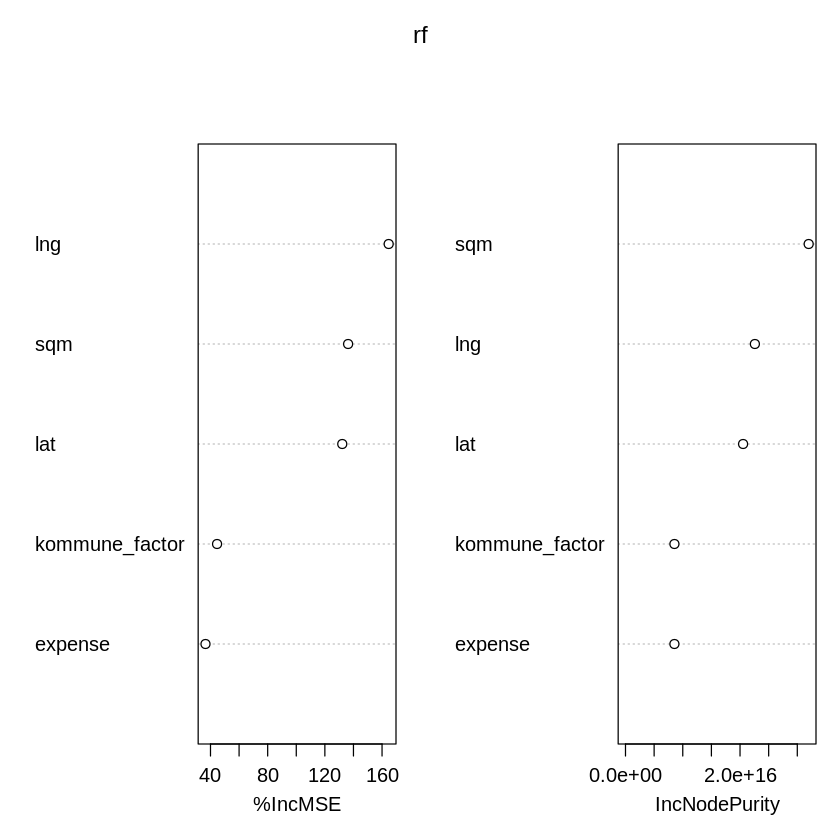

In [11]:
################### #
# Show importance plot of the model ----
# Using the package xgboost
################### #

varImpPlot(rf, scale = 0.2) 

In [24]:
pdf("preds_rf_plot.pdf") 


##################################### #
# Plot predictions ----
##################################### #
# Truth vs estimation
model_preds %>% 
  ggplot(aes(x = estimate/1000000, y = truth/1000000)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(x = "Predicted price [MNOK]",
       y = "Actual price [MNOK]") +
  theme_minimal()

dev.off()

png 
  2

In [25]:
pdf("hist_rf_plot.pdf") 
#Histogram of percentage error
model_preds %>%
  ggplot(aes(abs_dev_perc)) + 
  geom_histogram(fill = "dodgerblue3", color = "white", bins=50) +
  labs(title = "Histogram for percentage error",
       x     = "Percentage error",
       y     = "Count") +
  scale_x_continuous(limits = c(0,5), labels = scales::percent) +
  theme_minimal()

dev.off()

Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


png 
  2

In [26]:
pdf("dev_rf_plot.pdf") 
#Plot of abs_dev_perc by sqm (filter by total value > 5 million) 
model_preds %>%
  filter(truth > 5000000) %>%
  ggplot(aes(x = sqm, y = abs_dev_perc)) +
  geom_point(color = "dodgerblue3", alpha = 0.4) +
  labs(title = "Percentage error vs square meters",
       x     = "Square meters",
       y     = "Percentage error") +
  scale_y_continuous(limits = c(0, 10), labels = scales::percent) +
  xlim(0, 500) +
  theme_minimal()
dev.off()

Warning message:
“Removed 8 rows containing missing values (geom_point).”


png 
  2

In [27]:
pdf("dev_by_city_rf_plot.pdf")
# Plot of abs_dev_perc by sqm (for Troms? and Bod?)
model_preds %>%
  filter(kommune_name == "Oslo" | kommune_name == "Bergen") %>%
  ggplot(aes(x = sqm, y = abs_dev_perc, color = as.factor(kommune_name))) +
  geom_point() +
  labs(title = "Percentage error vs square meters",
       x     = "Square meters",
       y     = "Percentage error") +
  scale_y_continuous(labels = scales::percent) + 
  xlim(0, 500) +
  theme_minimal()
dev.off()

Warning message:
“Removed 2 rows containing missing values (geom_point).”


png 
  2

In [28]:
################### #
# Write prediction data to excel ----
################### #

write_xlsx(model_preds, "temp/rf_predictions.xlsx")

In [29]:

library("shapper")
library("DALEX")
train = data.frame(train)

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies


Attaching package: ‘DALEX’


The following object is masked from ‘package:dplyr’:

    explain




In [30]:
#install.packages("python-tk")
#install.packages("devtools")
#devtools::install_github("ModelOriented/shapper")
shapper::install_shap(conda = "/home/gunnar/anaconda3")
#reticulate::py_install(c('numpy', 'pandas'), envname = "base", conda = "/home/gunnar/anaconda3")

Using virtual environment '/home/gunnar/.virtualenvs/base' ...


Module(shap)

In [31]:
exp_rf <- explain(rf, data = train[,-3], y = train[,3])

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  15156  rows  5  cols 
  -> target variable   :  15156  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  275758.9 , mean =  3612734 , max =  50878039  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -4910722 , mean =  -7281.257 , max =  19121961  
  A new explainer has been created!  


In [32]:
ive_rf <- shap(exp_rf, new_observation = train[1,-3], conda = "/home/gunnar/anaconda3")

In [35]:
pdf("ai.pdf")

plot(ive_rf)
dev.off()

png 
  2